In [343]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from collections import OrderedDict

# Cell type predictions, library downsampled data

In [344]:
f_pred_dir = 'cell_type_classification/'
f_list = sorted(os.listdir(f_pred_dir))
f_list

['BIO_ddseq_1.LIBDS__cell_type_seurat.txt',
 'BIO_ddseq_2.LIBDS__cell_type_seurat.txt',
 'BIO_ddseq_3.LIBDS__cell_type_seurat.txt',
 'BIO_ddseq_4.LIBDS__cell_type_seurat.txt',
 'BRO_mtscatac_1.LIBDS__cell_type_seurat.txt',
 'BRO_mtscatac_2.LIBDS__cell_type_seurat.txt',
 'CNA_10xmultiome_1.LIBDS__cell_type_seurat.txt',
 'CNA_10xmultiome_2.LIBDS__cell_type_seurat.txt',
 'CNA_10xv11_1.LIBDS__cell_type_seurat.txt',
 'CNA_10xv11_2.LIBDS__cell_type_seurat.txt',
 'CNA_10xv11_3.LIBDS__cell_type_seurat.txt',
 'CNA_10xv11_4.LIBDS__cell_type_seurat.txt',
 'CNA_10xv11_5.LIBDS__cell_type_seurat.txt',
 'CNA_10xv2_1.LIBDS__cell_type_seurat.txt',
 'CNA_10xv2_2.LIBDS__cell_type_seurat.txt',
 'CNA_hydrop_1.LIBDS__cell_type_seurat.txt',
 'CNA_hydrop_2.LIBDS__cell_type_seurat.txt',
 'CNA_hydrop_3.LIBDS__cell_type_seurat.txt',
 'CNA_mtscatac_1.LIBDS__cell_type_seurat.txt',
 'CNA_mtscatac_2.LIBDS__cell_type_seurat.txt',
 'EPF_hydrop_1.LIBDS__cell_type_seurat.txt',
 'EPF_hydrop_2.LIBDS__cell_type_seurat.txt'

In [345]:
ct_pred = {}
for f in f_list:
    k = f.split('__')[0]
    ct_pred[k] = pd.read_csv(os.path.join(f_pred_dir, f), sep='\t')

In [346]:
ct_pred_dict = {}
ct_pred_dict['Libds'] = ct_pred.copy()

In [347]:
alias_dict = OrderedDict({
    "Broad_1": "BioRad ATAC 1",
    "Broad_2": "BioRad ATAC 2",
    "Stanford_1": "10x ATAC A1",
    "Stanford_2": "10x ATAC A2",
    "VIB_1": "10x ATAC B1",
    "VIB_2": "10x ATAC B2",
    "CNAG_1": "10x ATAC C1",
    "CNAG_2": "10x ATAC C2",
    "Broad_mito_1": "10x mtATAC 1",
    "Broad_mito_2": "10x mtATAC 2",
    "Sanger_1": "10x Multiome 1",
    "Sanger_2": "10x Multiome 2",
    "VIB_Hydrop_1": "Hydrop ATAC 1",
    "VIB_Hydrop_2": "Hydrop ATAC 2",
    "s3atac": "s3 ATAC",
    # "merged": "Merged"
})

In [348]:
ct_pred_alias = ct_pred_dict

### Fraction of cells passing thresholds

In [349]:
def calc_frac_cells_passing_threshold(ct_pred, order, step=0.1):
    # calculate fraction of cells passing thresholds
    step = 0.1
    tmp = []
    auc = {}
    threshold_dict = {}
    for k,x in {key: ct_pred[key] for key in order}.items():

        thrs = np.arange(0,1+step,step)
        tmpdf = pd.DataFrame([
            thrs,
            [ sum(x['cell_type_pred_score'] >= thr) for thr in thrs ],
        ]).T
        tmpdf.columns = ['Threshold', 'Score']

        tmpdf['Score'] = tmpdf['Score']/x.shape[0]
        auc[k] = np.trapz(tmpdf['Score'].to_numpy(), x=tmpdf['Threshold'].to_numpy() )
        #tmpdf['Sample'] = k
        tmpdf['Sample'] = f"{k} ({round(auc[k],3)})"
        threshold_dict[k] = round(auc[k],3)
        tmp.append(tmpdf)
        #break
    tp = pd.concat(tmp, ignore_index=True)
    return tp, threshold_dict


def plot_frac_cells_passing_threshold(tp, ax, title="", leg_size=8,
                                      x='Threshold', y='Score',
                                      hue='Sample',
                                      style='Sample',
                                      palette='tab20',
                                      hue_order=None
                                     ):
    #dashes=[(''),(2,1)] * int(tp['Sample'].unique().size/2) + ['']
    n = tp['Sample'].unique().size
    if((n % 2) == 0):
        dashes=[(''),(2,1)] * int(n/2)
    else:
        dashes=[(''),(2,1)] * int(n/2) + ['']

    sns.lineplot(x=x, y=y,
                 hue=hue,
                 style=style,
                 dashes=dashes,
                 markers=True,
                 ax=ax,
                 palette=palette,
                 #size=0.8, #alpha=0.8,
                 lw=1,
                 data=tp,
                 hue_order=hue_order)
    ax.set_xlabel('Threshold on prediction score')
    ax.set_ylabel('Fraction of cells passing threshold')
    #plt.legend(bbox_to_anchor=(1.025, 1), loc=2, borderaxespad=0., fontsize=8)
    ax.grid(color='0.9')
    ax.legend(loc=3, fontsize=leg_size)
    ax.set_title(title)

In [350]:
# reorder legends function
import numpy as np
#  Returns tuple of handles, labels for axis ax, after reordering them to conform to the label order `order`, and if unique is True, after removing entries with duplicate labels.
def reorderLegend(ax=None,order=None,unique=False):
    if ax is None: ax=plt.gca()
    handles, labels = ax.get_legend_handles_labels()
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0])) # sort both labels and handles by labels
    if order is not None: # Sort according to a given list (not necessarily complete)
        keys=dict(zip(order,range(len(order))))
        labels, handles = zip(*sorted(zip(labels, handles), key=lambda t,keys=keys: keys.get(t[0],np.inf)))
    if unique:  labels, handles= zip(*unique_everseen(zip(labels,handles), key = labels)) # Keep only the first of each handle
    ax.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) # i modified this line 

    return(handles, labels)


def unique_everseen(seq, key=None):
    seen = set()
    seen_add = seen.add
    return [x for x,k in zip(seq,key) if not (k in seen or seen_add(k))]

#source: https://stackoverflow.com/questions/22263807/how-is-order-of-items-in-matplotlib-legend-determined

In [351]:
order = [alias_dict[x] for x in alias_dict.keys()]

In [352]:
order = ct_pred_dict.keys()

In [353]:
ct_pred.keys()

dict_keys(['BIO_ddseq_1.LIBDS', 'BIO_ddseq_2.LIBDS', 'BIO_ddseq_3.LIBDS', 'BIO_ddseq_4.LIBDS', 'BRO_mtscatac_1.LIBDS', 'BRO_mtscatac_2.LIBDS', 'CNA_10xmultiome_1.LIBDS', 'CNA_10xmultiome_2.LIBDS', 'CNA_10xv11_1.LIBDS', 'CNA_10xv11_2.LIBDS', 'CNA_10xv11_3.LIBDS', 'CNA_10xv11_4.LIBDS', 'CNA_10xv11_5.LIBDS', 'CNA_10xv2_1.LIBDS', 'CNA_10xv2_2.LIBDS', 'CNA_hydrop_1.LIBDS', 'CNA_hydrop_2.LIBDS', 'CNA_hydrop_3.LIBDS', 'CNA_mtscatac_1.LIBDS', 'CNA_mtscatac_2.LIBDS', 'EPF_hydrop_1.LIBDS', 'EPF_hydrop_2.LIBDS', 'EPF_hydrop_3.LIBDS', 'EPF_hydrop_4.LIBDS', 'HAR_ddseq_1.LIBDS', 'HAR_ddseq_2.LIBDS', 'MDC_mtscatac_2.LIBDS', 'OHS_s3atac_1.LIBDS', 'OHS_s3atac_2.LIBDS', 'SAN_10xmultiome_1.LIBDS', 'SAN_10xmultiome_2.LIBDS', 'STA_10xv11_1.LIBDS', 'STA_10xv11_2.LIBDS', 'TXG_10xv2_2.LIBDS', 'VIB_10xmultiome_1.LIBDS', 'VIB_10xmultiome_2.LIBDS', 'VIB_10xv1_1.LIBDS', 'VIB_10xv1_2.LIBDS', 'VIB_10xv2_1.LIBDS', 'VIB_10xv2_2.LIBDS', 'VIB_hydrop_11.LIBDS', 'VIB_hydrop_12.LIBDS', 'VIB_hydrop_21.LIBDS', 'VIB_hydrop_2

In [354]:
tp, threshold_dict = calc_frac_cells_passing_threshold(ct_pred, order=ct_pred.keys(), step=0.1)

In [355]:
threshold_dict

{'BIO_ddseq_1.LIBDS': 0.721,
 'BIO_ddseq_2.LIBDS': 0.739,
 'BIO_ddseq_3.LIBDS': 0.74,
 'BIO_ddseq_4.LIBDS': 0.752,
 'BRO_mtscatac_1.LIBDS': 0.821,
 'BRO_mtscatac_2.LIBDS': 0.82,
 'CNA_10xmultiome_1.LIBDS': 0.759,
 'CNA_10xmultiome_2.LIBDS': 0.638,
 'CNA_10xv11_1.LIBDS': 0.805,
 'CNA_10xv11_2.LIBDS': 0.791,
 'CNA_10xv11_3.LIBDS': 0.788,
 'CNA_10xv11_4.LIBDS': 0.8,
 'CNA_10xv11_5.LIBDS': 0.795,
 'CNA_10xv2_1.LIBDS': 0.783,
 'CNA_10xv2_2.LIBDS': 0.791,
 'CNA_hydrop_1.LIBDS': 0.495,
 'CNA_hydrop_2.LIBDS': 0.533,
 'CNA_hydrop_3.LIBDS': 0.519,
 'CNA_mtscatac_1.LIBDS': 0.726,
 'CNA_mtscatac_2.LIBDS': 0.736,
 'EPF_hydrop_1.LIBDS': 0.605,
 'EPF_hydrop_2.LIBDS': 0.558,
 'EPF_hydrop_3.LIBDS': 0.584,
 'EPF_hydrop_4.LIBDS': 0.602,
 'HAR_ddseq_1.LIBDS': 0.797,
 'HAR_ddseq_2.LIBDS': 0.767,
 'MDC_mtscatac_2.LIBDS': 0.692,
 'OHS_s3atac_1.LIBDS': 0.564,
 'OHS_s3atac_2.LIBDS': 0.414,
 'SAN_10xmultiome_1.LIBDS': 0.782,
 'SAN_10xmultiome_2.LIBDS': 0.767,
 'STA_10xv11_1.LIBDS': 0.724,
 'STA_10xv11_2.LIBDS':

# NOTE: the samples will be dislpayed in the order of this dict!
color_dict = OrderedDict({
    "BioRad ATAC 1": "#1f77b4",
    "BioRad ATAC 2": "#aec7e8",
    "10x ATAC A1": "#ff7f0e",
    "10x ATAC A2": "#ffbb78",
    "10x ATAC B1": "#2ca02c",
    "10x ATAC B2": "#98df8a",
    "10x ATAC C1": "#d62728",
    "10x ATAC C2": "#ff9896",
    "10x mtATAC 1": "#9467bd",
    "10x mtATAC 2": "#c5b0d5",
    "10x Multiome 1": "#8c564b",
    "10x Multiome 2": "#c49c94",
    "Hydrop ATAC 1": "#e377c2",
    "Hydrop ATAC 2": "#f7b6d2",
    "s3 ATAC": "#7f7f7f",
    # "Merged": "#111111"
})

In [356]:
color = "#1f77b4"
color_dict = {key: color for key in ct_pred.keys()}

In [357]:
color_dict_thr = {}
for x in color_dict.keys():
    color_dict_thr[x + ' (' + str(threshold_dict[x]) + ')'] = color_dict[x]

In [358]:
sorted(list(color_dict_thr.keys()))

['BIO_ddseq_1.LIBDS (0.721)',
 'BIO_ddseq_2.LIBDS (0.739)',
 'BIO_ddseq_3.LIBDS (0.74)',
 'BIO_ddseq_4.LIBDS (0.752)',
 'BRO_mtscatac_1.LIBDS (0.821)',
 'BRO_mtscatac_2.LIBDS (0.82)',
 'CNA_10xmultiome_1.LIBDS (0.759)',
 'CNA_10xmultiome_2.LIBDS (0.638)',
 'CNA_10xv11_1.LIBDS (0.805)',
 'CNA_10xv11_2.LIBDS (0.791)',
 'CNA_10xv11_3.LIBDS (0.788)',
 'CNA_10xv11_4.LIBDS (0.8)',
 'CNA_10xv11_5.LIBDS (0.795)',
 'CNA_10xv2_1.LIBDS (0.783)',
 'CNA_10xv2_2.LIBDS (0.791)',
 'CNA_hydrop_1.LIBDS (0.495)',
 'CNA_hydrop_2.LIBDS (0.533)',
 'CNA_hydrop_3.LIBDS (0.519)',
 'CNA_mtscatac_1.LIBDS (0.726)',
 'CNA_mtscatac_2.LIBDS (0.736)',
 'EPF_hydrop_1.LIBDS (0.605)',
 'EPF_hydrop_2.LIBDS (0.558)',
 'EPF_hydrop_3.LIBDS (0.584)',
 'EPF_hydrop_4.LIBDS (0.602)',
 'HAR_ddseq_1.LIBDS (0.797)',
 'HAR_ddseq_2.LIBDS (0.767)',
 'MDC_mtscatac_2.LIBDS (0.692)',
 'OHS_s3atac_1.LIBDS (0.564)',
 'OHS_s3atac_2.LIBDS (0.414)',
 'SAN_10xmultiome_1.LIBDS (0.782)',
 'SAN_10xmultiome_2.LIBDS (0.767)',
 'STA_10xv11_1.LIBDS 

In [359]:
order_thr = color_dict_thr.keys()

In [360]:
tp['tech'] = [x.split('_')[1] for x in tp['Sample']]

In [361]:
tp

,Threshold,Score,Sample,tech
0,0.0,1.000000,BIO_ddseq_1.LIBDS (0.721),ddseq
1,0.1,1.000000,BIO_ddseq_1.LIBDS (0.721),ddseq
2,0.2,1.000000,BIO_ddseq_1.LIBDS (0.721),ddseq
3,0.3,0.999295,BIO_ddseq_1.LIBDS (0.721),ddseq
4,0.4,0.992070,BIO_ddseq_1.LIBDS (0.721),ddseq
...,...,...,...,...
479,0.6,0.400996,VIB_hydrop_22.LIBDS (0.585),hydrop
480,0.7,0.246575,VIB_hydrop_22.LIBDS (0.585),hydrop
481,0.8,0.125778,VIB_hydrop_22.LIBDS (0.585),hydrop
482,0.9,0.051059,VIB_hydrop_22.LIBDS (0.585),hydrop


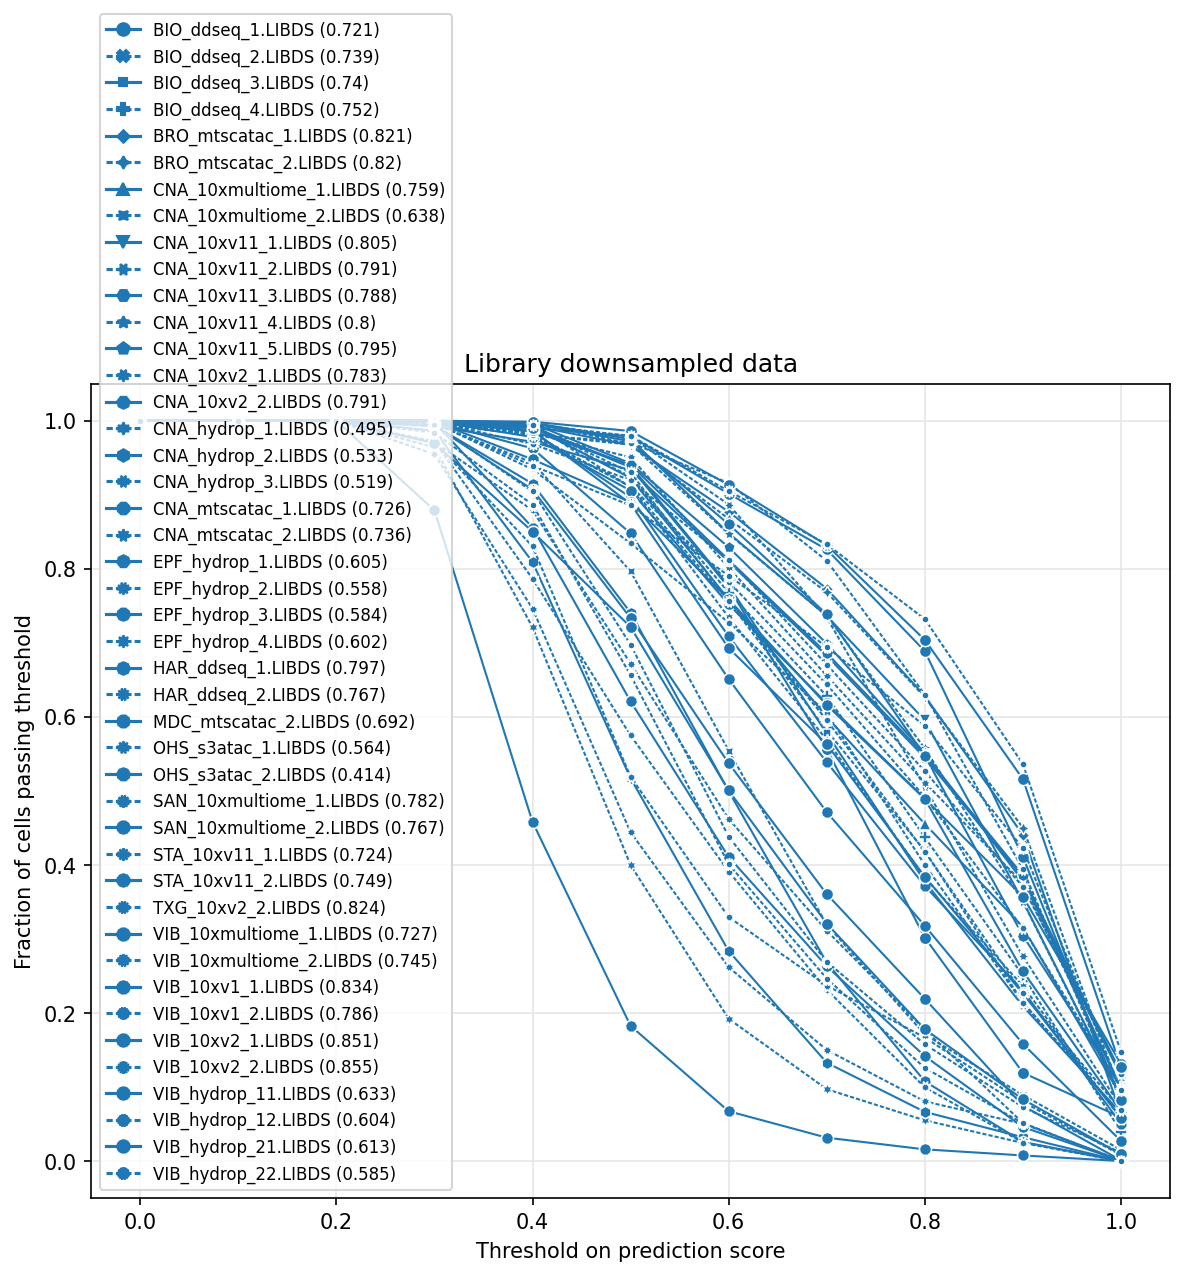

In [362]:
fig, ax = plt.subplots(1,1, figsize=(8,8), dpi=150 )
plot_frac_cells_passing_threshold(tp, ax, title="Library downsampled data", palette=color_dict_thr)
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.tight_layout()
# reorderLegend(ax, order_thr)
tp['Dataset'] = "Library downsampled data"
# plt_pred['Libds'] = tp.copy()
# plt.savefig(f'plts_pub/libds_label_transfer.png', transparent=False, bbox_inches='tight', facecolor='white', dpi=300)
# plt.savefig(f'plts_pub/libds_label_transfer.svg', transparent=False, bbox_inches='tight', facecolor='white', dpi=300)

In [363]:
sorted(tp['Sample'].unique())

['BIO_ddseq_1.LIBDS (0.721)',
 'BIO_ddseq_2.LIBDS (0.739)',
 'BIO_ddseq_3.LIBDS (0.74)',
 'BIO_ddseq_4.LIBDS (0.752)',
 'BRO_mtscatac_1.LIBDS (0.821)',
 'BRO_mtscatac_2.LIBDS (0.82)',
 'CNA_10xmultiome_1.LIBDS (0.759)',
 'CNA_10xmultiome_2.LIBDS (0.638)',
 'CNA_10xv11_1.LIBDS (0.805)',
 'CNA_10xv11_2.LIBDS (0.791)',
 'CNA_10xv11_3.LIBDS (0.788)',
 'CNA_10xv11_4.LIBDS (0.8)',
 'CNA_10xv11_5.LIBDS (0.795)',
 'CNA_10xv2_1.LIBDS (0.783)',
 'CNA_10xv2_2.LIBDS (0.791)',
 'CNA_hydrop_1.LIBDS (0.495)',
 'CNA_hydrop_2.LIBDS (0.533)',
 'CNA_hydrop_3.LIBDS (0.519)',
 'CNA_mtscatac_1.LIBDS (0.726)',
 'CNA_mtscatac_2.LIBDS (0.736)',
 'EPF_hydrop_1.LIBDS (0.605)',
 'EPF_hydrop_2.LIBDS (0.558)',
 'EPF_hydrop_3.LIBDS (0.584)',
 'EPF_hydrop_4.LIBDS (0.602)',
 'HAR_ddseq_1.LIBDS (0.797)',
 'HAR_ddseq_2.LIBDS (0.767)',
 'MDC_mtscatac_2.LIBDS (0.692)',
 'OHS_s3atac_1.LIBDS (0.564)',
 'OHS_s3atac_2.LIBDS (0.414)',
 'SAN_10xmultiome_1.LIBDS (0.782)',
 'SAN_10xmultiome_2.LIBDS (0.767)',
 'STA_10xv11_1.LIBDS 

ddseq


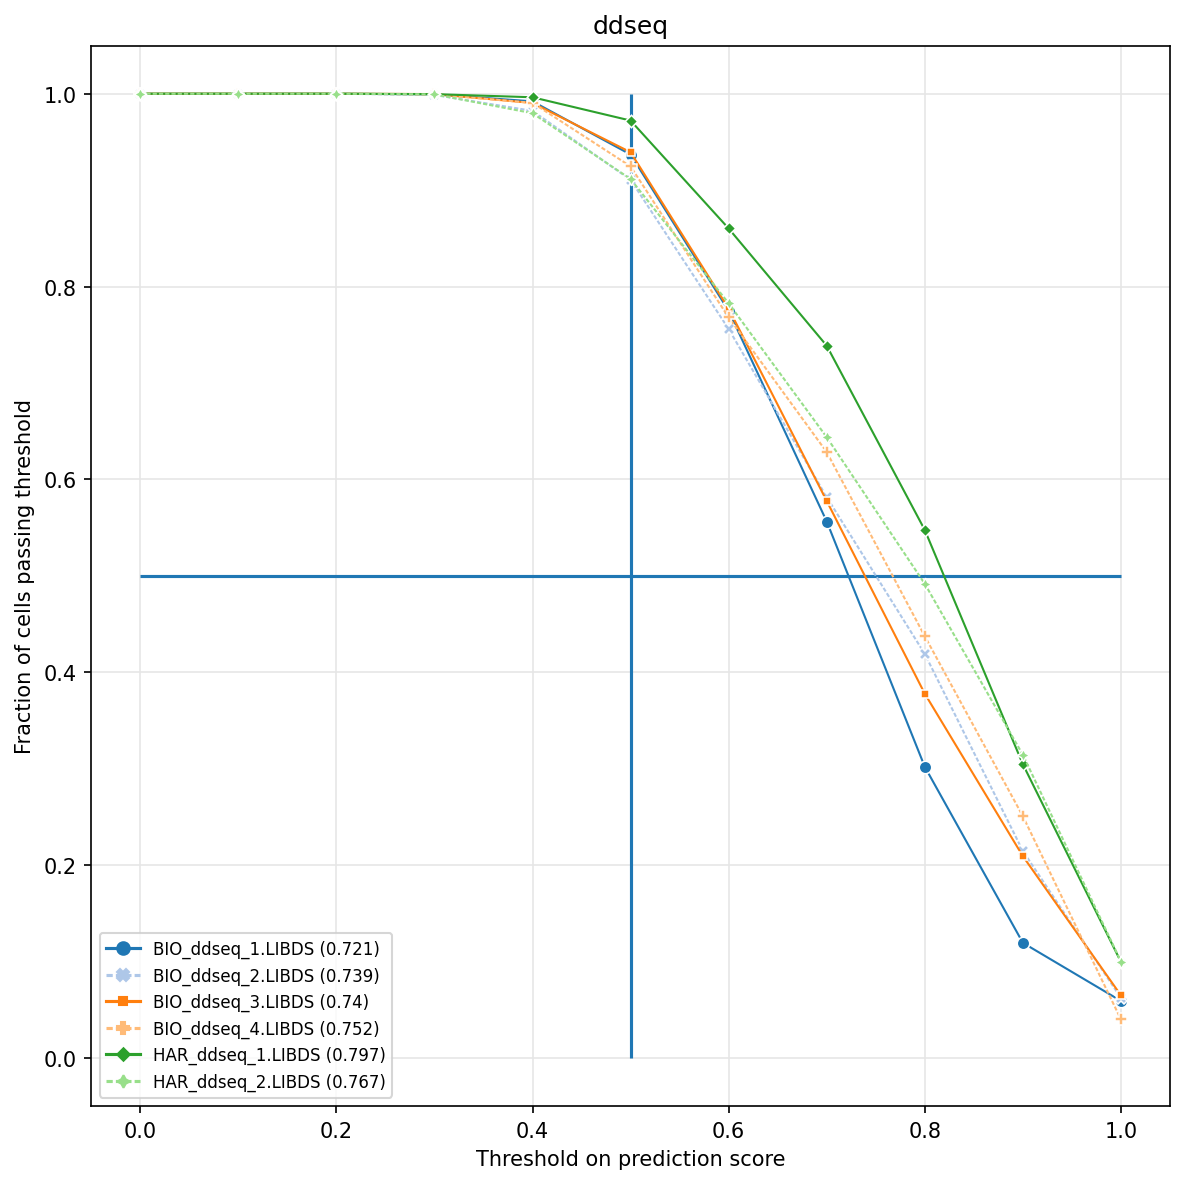

mtscatac


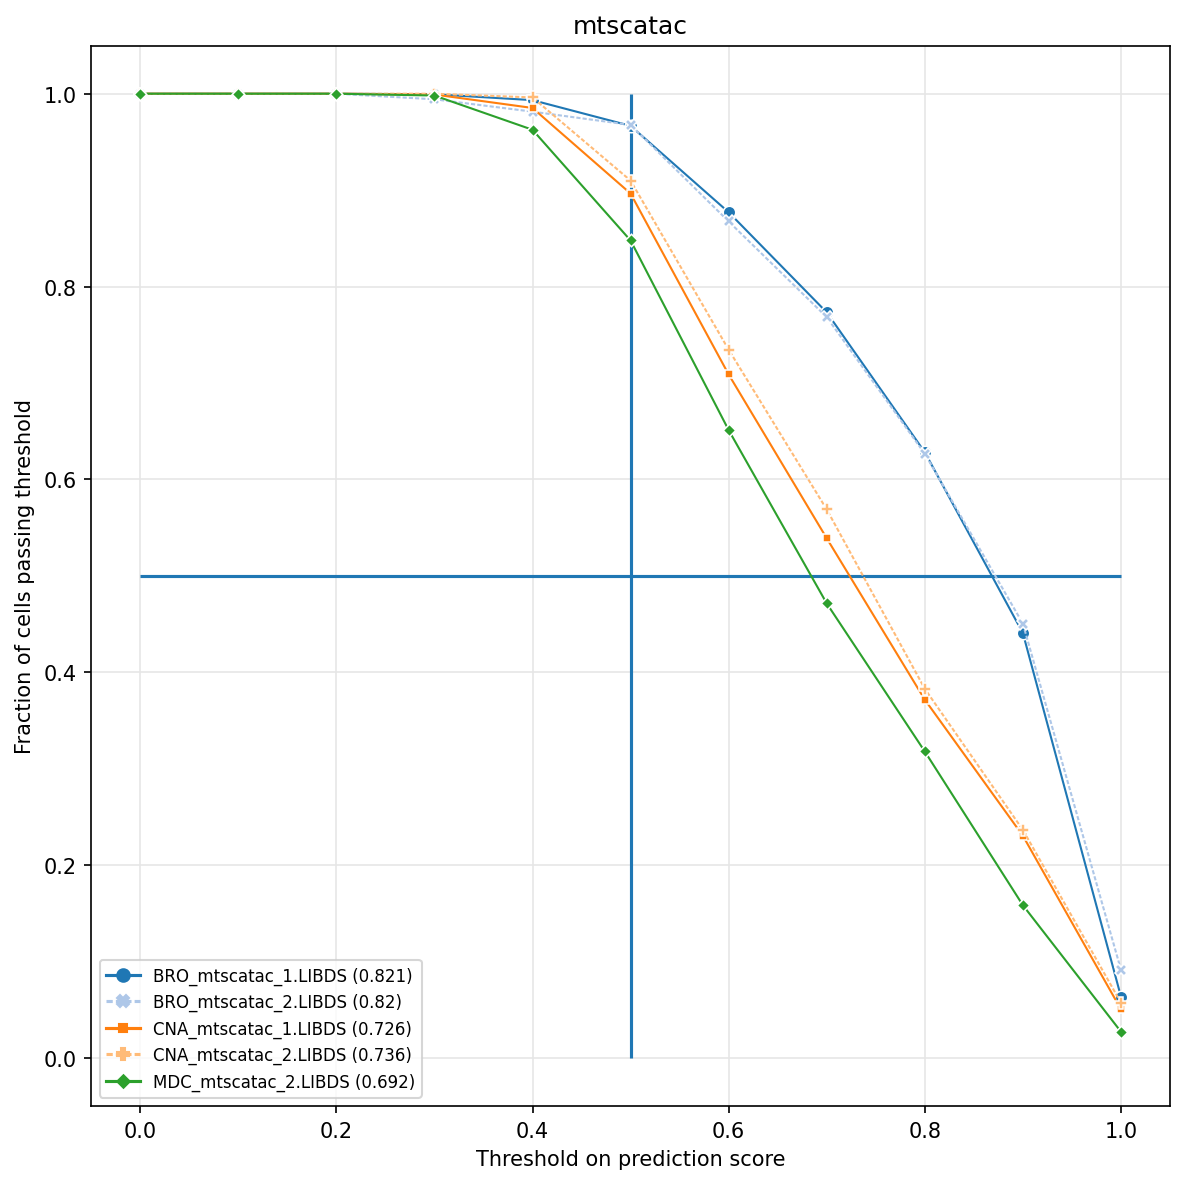

10xmultiome


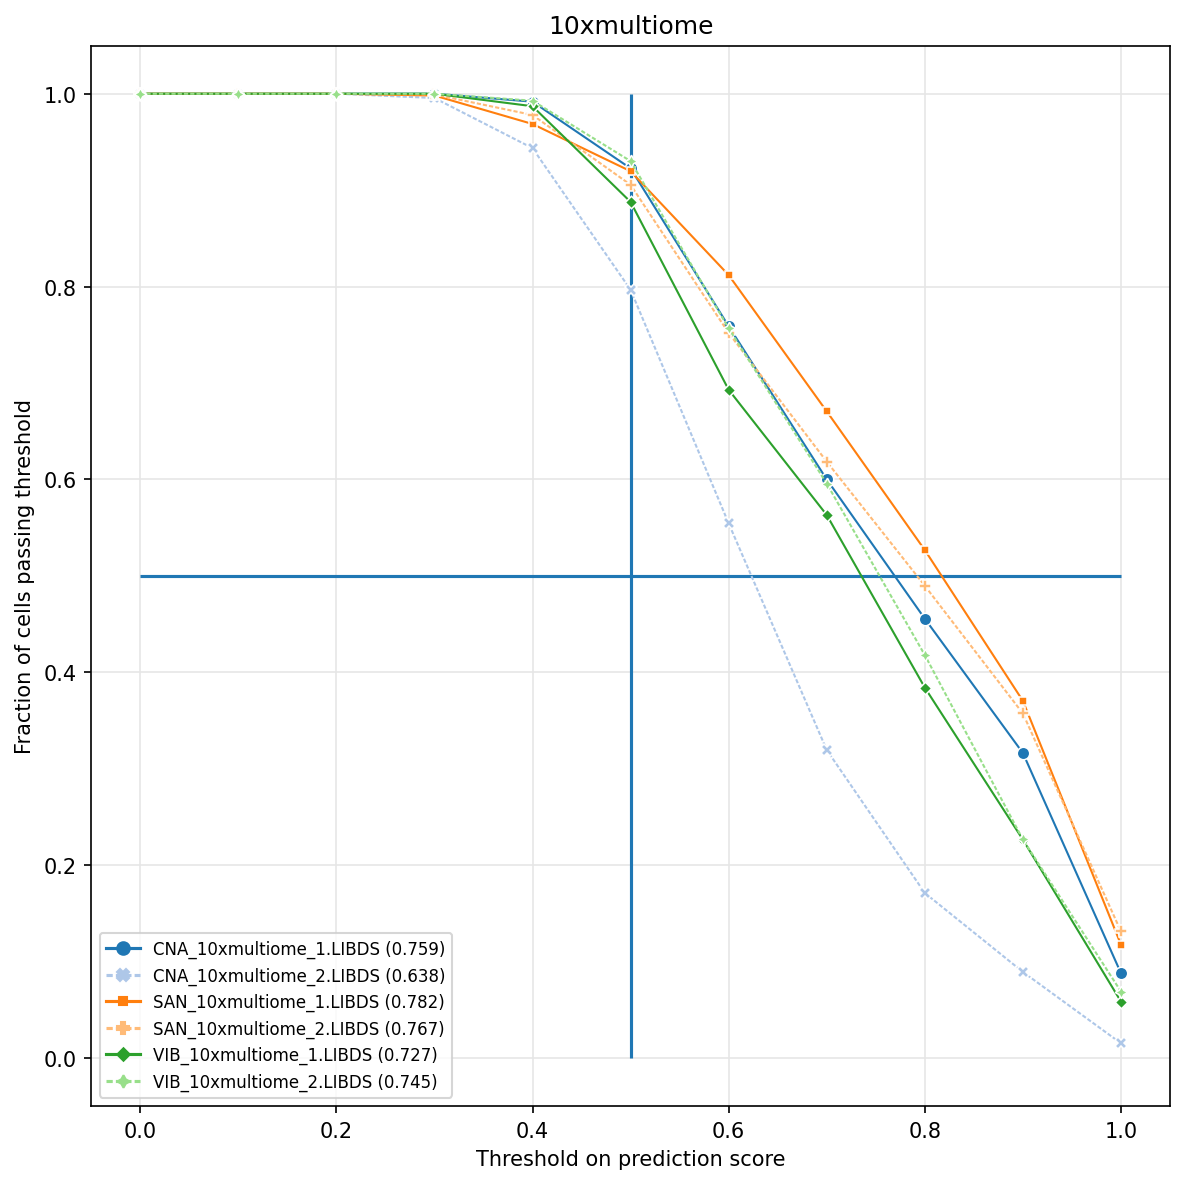

10xv11


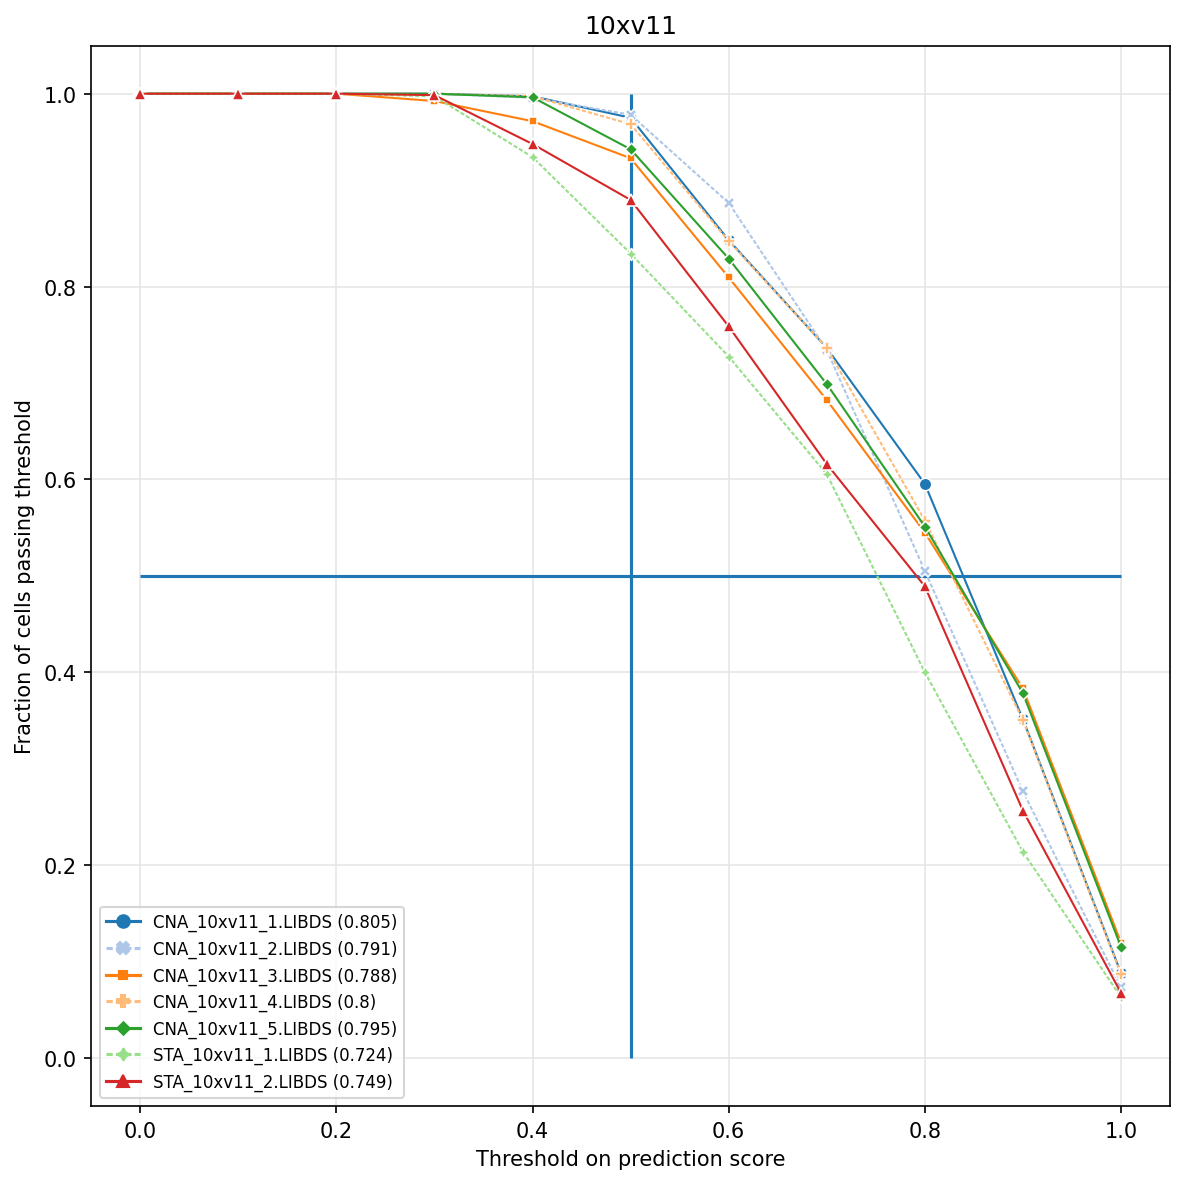

10xv2


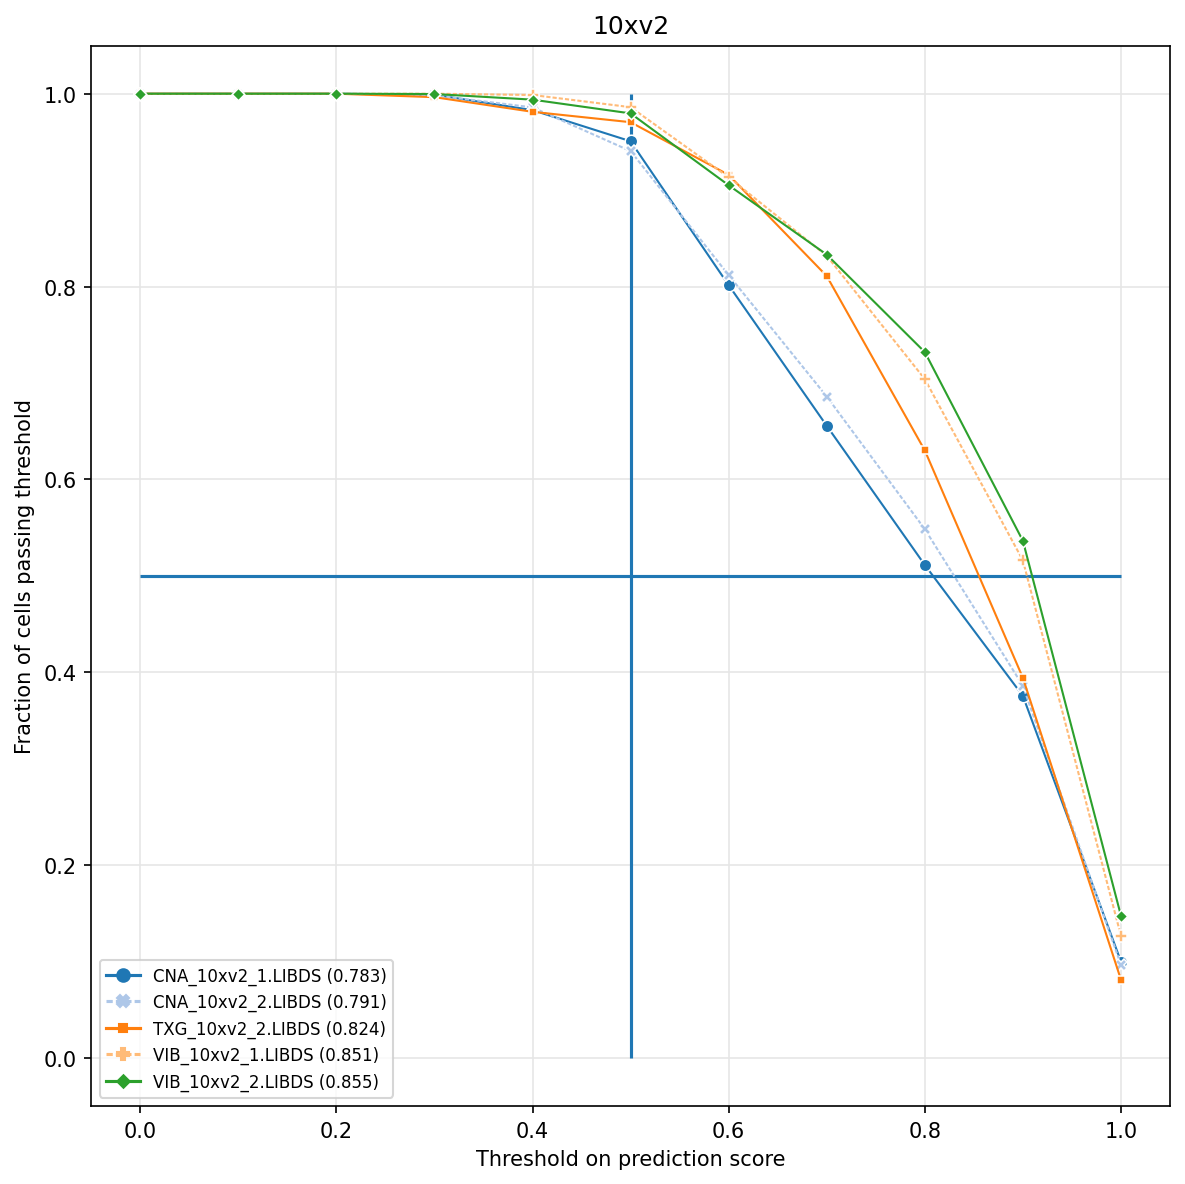

hydrop


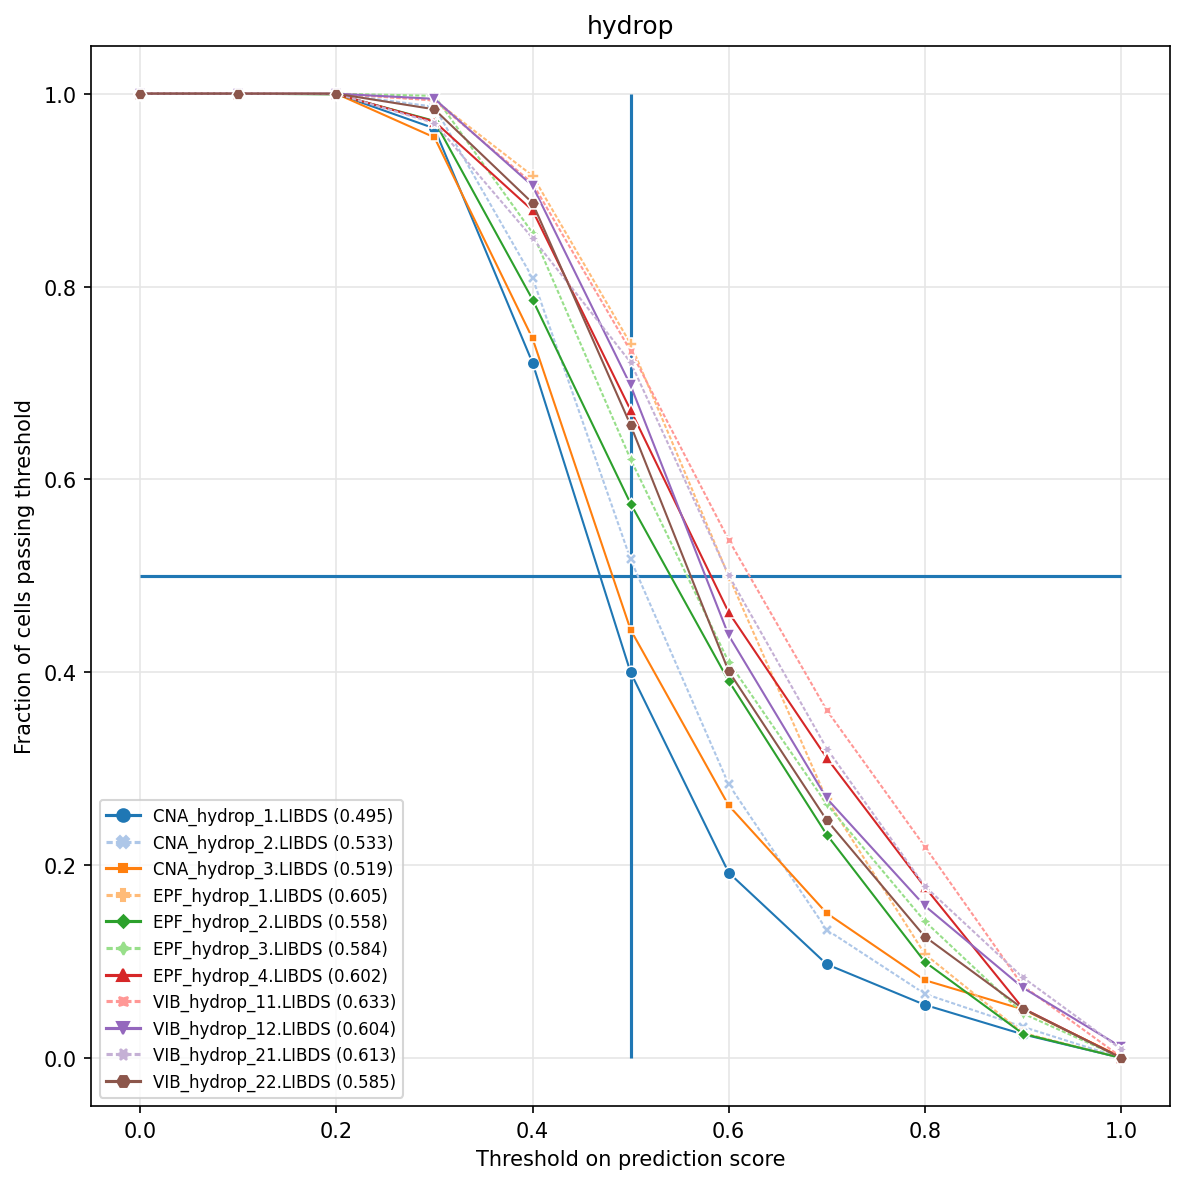

s3atac


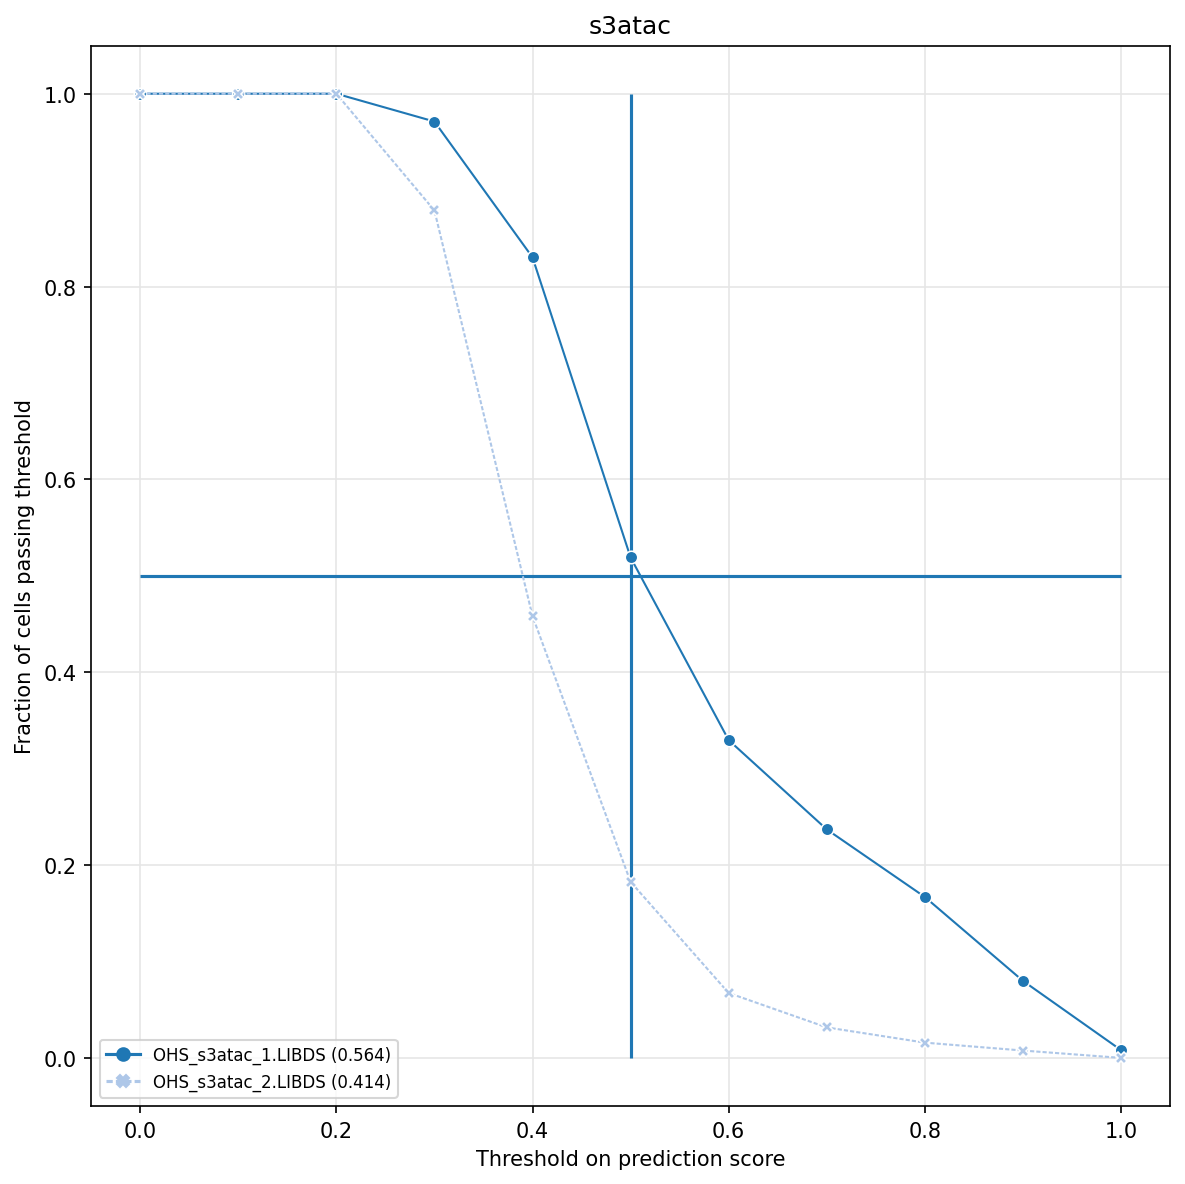

10xv1


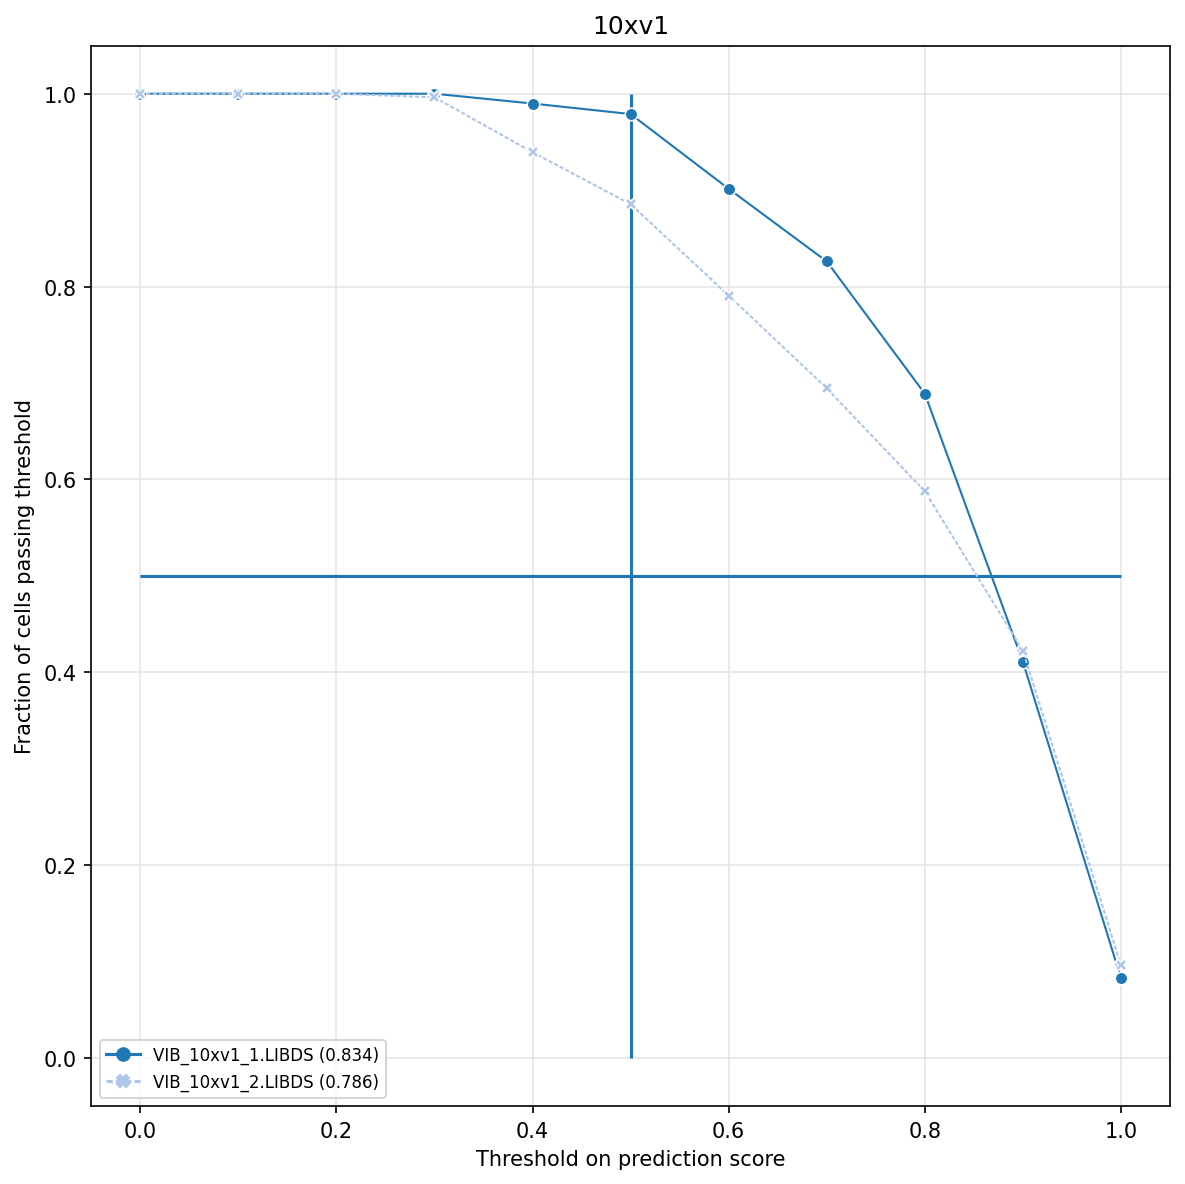

In [364]:
for tech in tp['tech'].unique():
    print(tech)
    tp_sub = tp[tp['tech'] == tech]
    
    fig, ax = plt.subplots(1,1, figsize=(8,8), dpi=150)
    order = sorted(tp_sub['Sample'].unique())
    ax.vlines(x=0.5, ymin=0, ymax=1)
    ax.hlines(y=0.5, xmin=0, xmax=1)

    plot_frac_cells_passing_threshold(tp_sub, ax, title=tech, hue_order=order)
    # plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    plt.tight_layout()
    plt.show()
    plt.close()

In [370]:
tp

,sample_id,cell_type,fraction
0,BIO_ddseq_1.LIBDS,B cell,0.069251
1,BIO_ddseq_1.LIBDS,CD14+ monocyte,0.172511
2,BIO_ddseq_1.LIBDS,CD16+ monocyte,0.006167
3,BIO_ddseq_1.LIBDS,CD4+ T cell,0.460969
4,BIO_ddseq_1.LIBDS,Cytotoxic T cell,0.208634
...,...,...,...
301,VIB_hydrop_22.LIBDS,CD16+ monocyte,0.022416
302,VIB_hydrop_22.LIBDS,CD4+ T cell,0.212951
303,VIB_hydrop_22.LIBDS,Cytotoxic T cell,0.211706
304,VIB_hydrop_22.LIBDS,Dendritic cell,0.004981


In [371]:
tech_list = ['ddseq', '10xv2']
tp_sub = pd.DataFrame()
tp_sub_sub = pd.DataFrame()
for tech in tech_list:
    tp_sub_sub = tp[tp['tech'] == tech]
    tp_sub = pd.concat([tp_sub, tp_sub_sub])

fig, ax = plt.subplots(1,1, figsize=(8,8), dpi=150)
order = sorted(tp_sub['Sample'].unique())
ax.vlines(x=0.5, ymin=0, ymax=1)
ax.hlines(y=0.5, xmin=0, xmax=1)

plot_frac_cells_passing_threshold(tp_sub, ax, title='techs', hue_order=order)
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.tight_layout()
plt.show()
plt.close()

KeyError: 'tech'

### Cell type distributions

In [374]:
def calc_cell_type_dist(ct_pred, order):
    tp = pd.concat([ ct_pred[key] for key in order])
    tp_counts = tp[['sample_id','cell_type']].groupby(['sample_id','cell_type']).size().rename('counts')
    tp = tp_counts.groupby(level=0).apply(lambda x: x / x.sum() ).reset_index(name='fraction')
    return tp   

In [375]:
tp = calc_cell_type_dist(ct_pred, ct_pred.keys())

In [376]:
tp['sample_id'].unique()

array(['BIO_ddseq_1.LIBDS', 'BIO_ddseq_2.LIBDS', 'BIO_ddseq_3.LIBDS',
       'BIO_ddseq_4.LIBDS', 'BRO_mtscatac_1.LIBDS',
       'BRO_mtscatac_2.LIBDS', 'CNA_10xmultiome_1.LIBDS',
       'CNA_10xmultiome_2.LIBDS', 'CNA_10xv11_1.LIBDS',
       'CNA_10xv11_2.LIBDS', 'CNA_10xv11_3.LIBDS', 'CNA_10xv11_4.LIBDS',
       'CNA_10xv11_5.LIBDS', 'CNA_10xv2_1.LIBDS', 'CNA_10xv2_2.LIBDS',
       'CNA_hydrop_1.LIBDS', 'CNA_hydrop_2.LIBDS', 'CNA_hydrop_3.LIBDS',
       'CNA_mtscatac_1.LIBDS', 'CNA_mtscatac_2.LIBDS',
       'EPF_hydrop_1.LIBDS', 'EPF_hydrop_2.LIBDS', 'EPF_hydrop_3.LIBDS',
       'EPF_hydrop_4.LIBDS', 'HAR_ddseq_1.LIBDS', 'HAR_ddseq_2.LIBDS',
       'MDC_mtscatac_2.LIBDS', 'OHS_s3atac_1.LIBDS', 'OHS_s3atac_2.LIBDS',
       'SAN_10xmultiome_1.LIBDS', 'SAN_10xmultiome_2.LIBDS',
       'STA_10xv11_1.LIBDS', 'STA_10xv11_2.LIBDS', 'TXG_10xv2_2.LIBDS',
       'VIB_10xmultiome_1.LIBDS', 'VIB_10xmultiome_2.LIBDS',
       'VIB_10xv1_1.LIBDS', 'VIB_10xv1_2.LIBDS', 'VIB_10xv2_1.LIBDS',
       'V

tp['name'] = [alias_dict[x] for x in tp['sample_id']]

In [377]:
tp['name'] = tp['sample_id']

In [378]:
def plot_cell_type_dist(tp, ax, title="", leg_size=7, leg_on=True, palette='tab20', order=None):
    g = sns.barplot(data=tp,
        x="cell_type", y="fraction", hue="name", hue_order=order,
        palette=palette, alpha=1,# height=6,
        ax=ax
    )
    ax.set_xlabel('')
    ax.set_ylabel('Fraction of cells')
    g.set_xticklabels(g.get_xticklabels(), rotation=15, ha='right', fontsize=8)
    #plt.legend(bbox_to_anchor=(1.025, 1), loc=2, borderaxespad=0., fontsize=8)
    ax.grid(color='0.9', axis='y')
    ax.legend(loc=0, fontsize=leg_size)
    ax.set_title(title, fontsize=8)
    return g

In [379]:
tp['tech'] = [x.split('_')[1] for x in tp['sample_id']]

ddseq


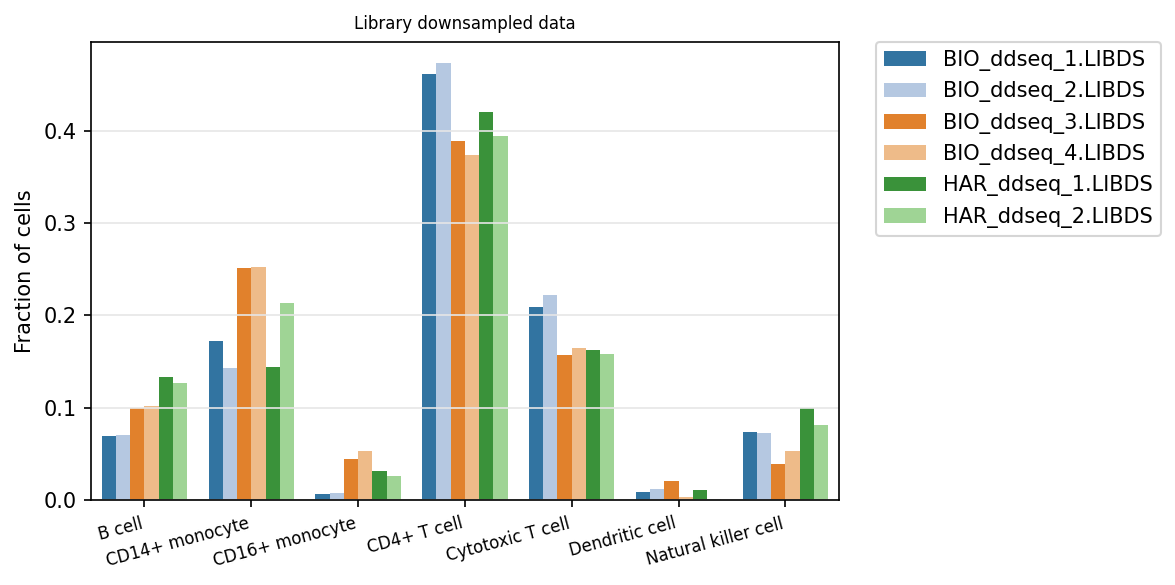

mtscatac


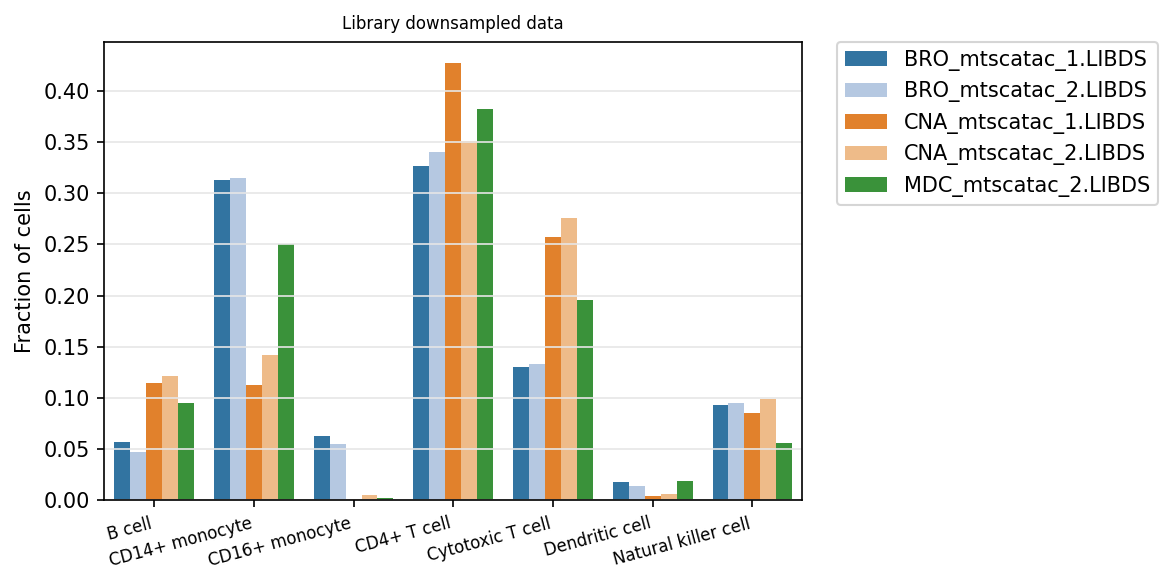

10xmultiome


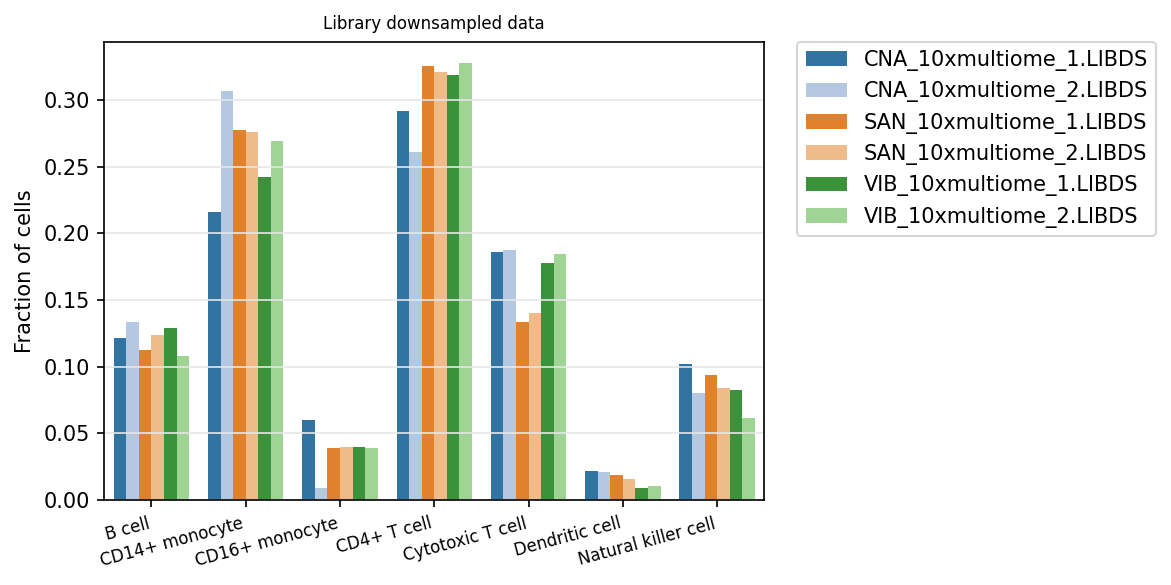

10xv11


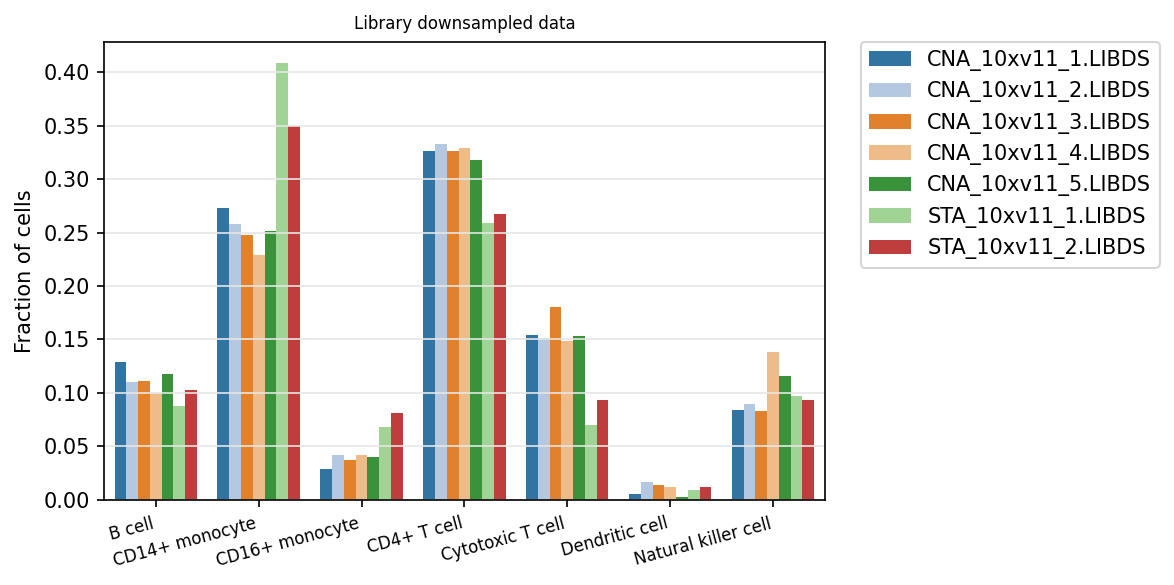

10xv2


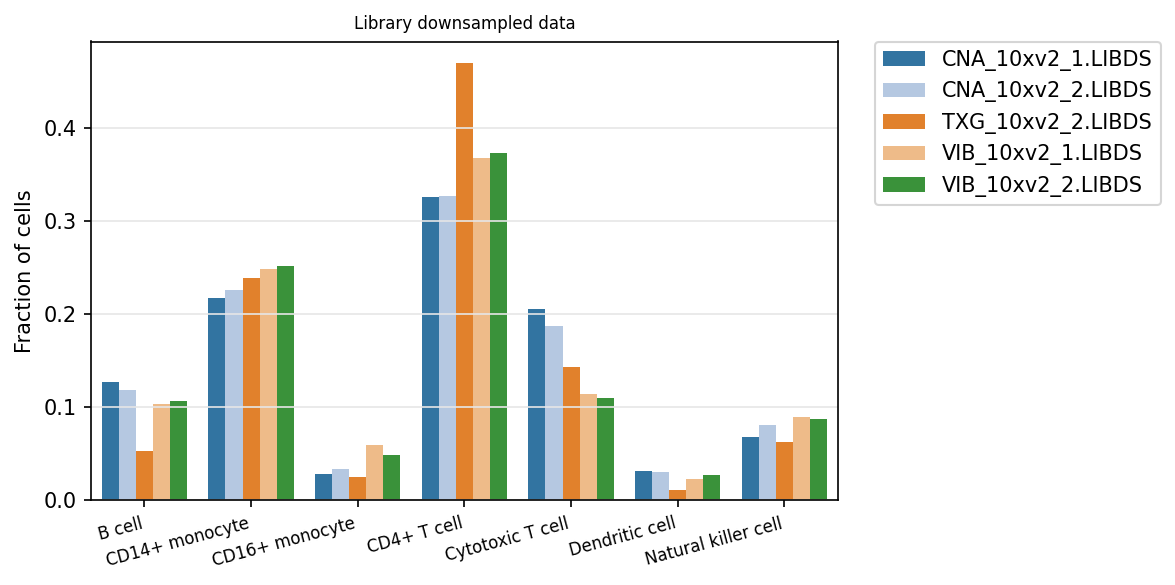

hydrop


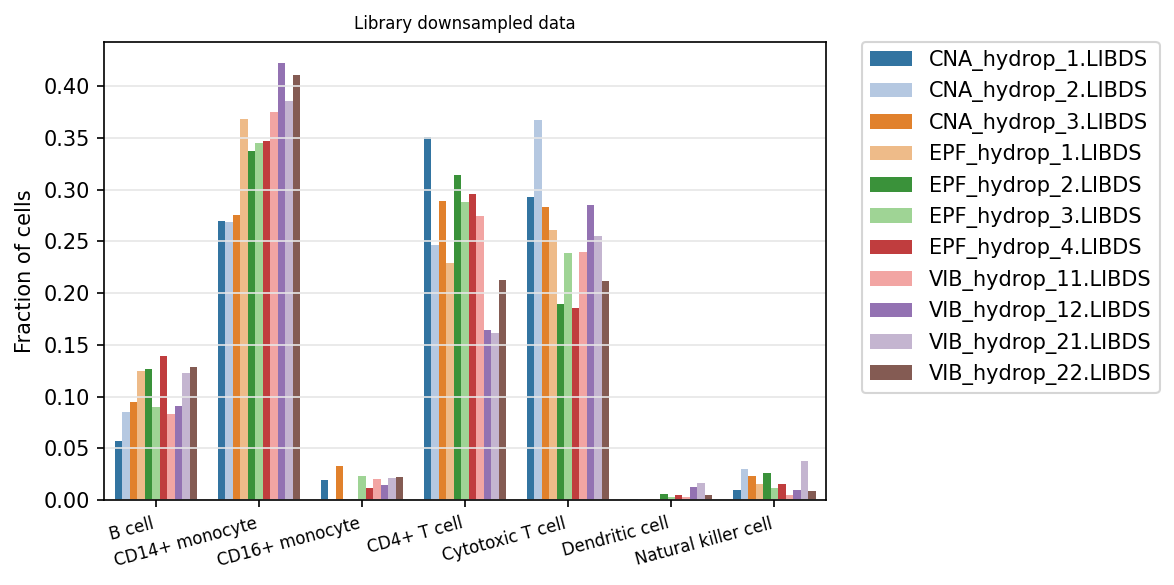

s3atac


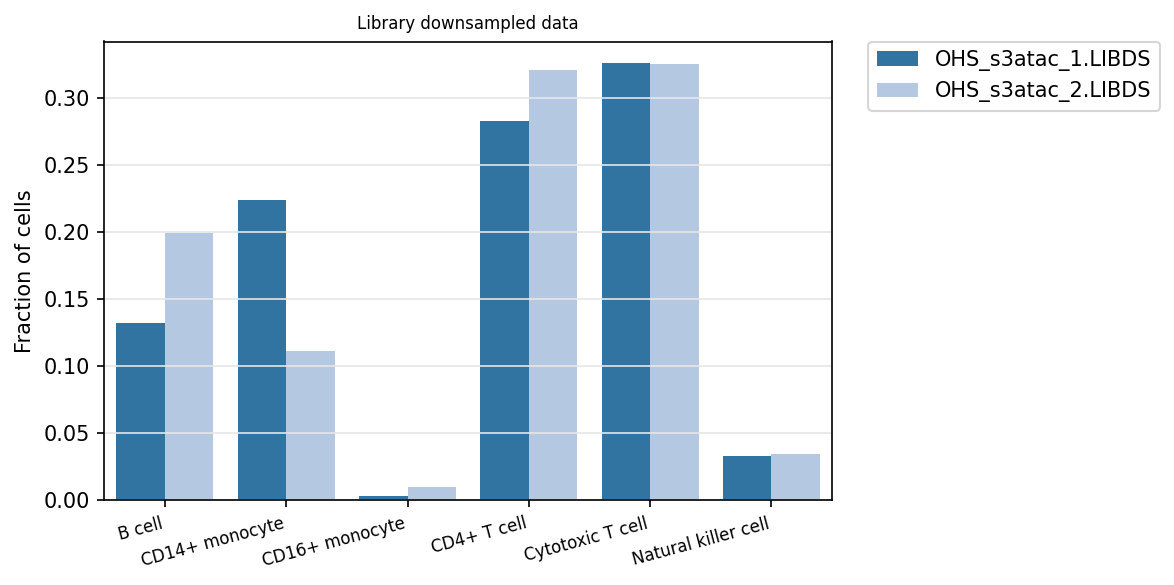

10xv1


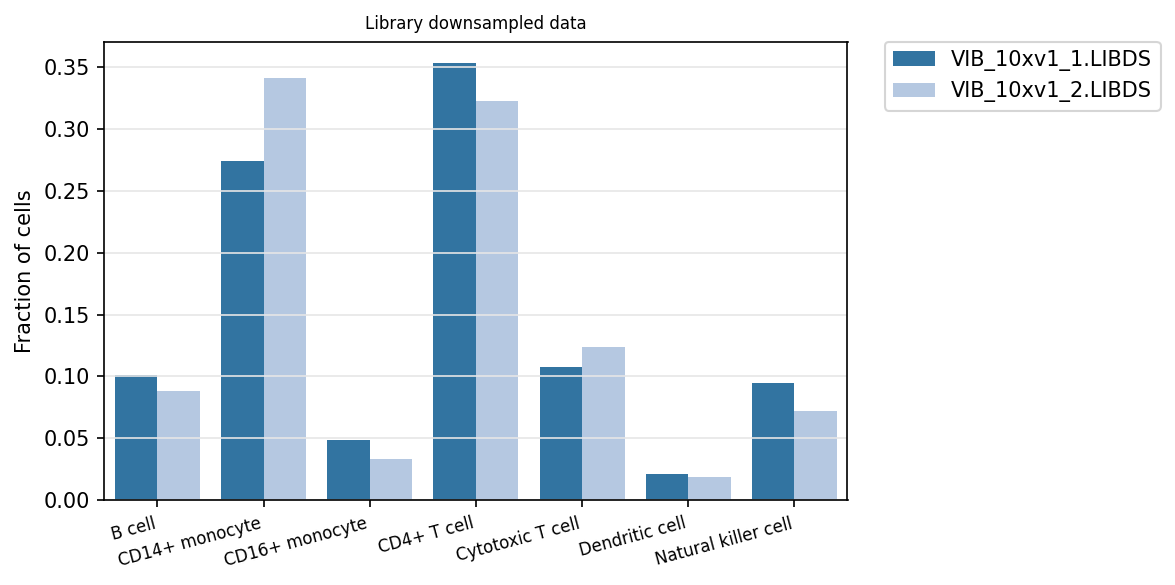

In [382]:
for tech in tp['tech'].unique():
    print(tech)
    tp_sub = tp[tp['tech'] == tech]
    
    fig, ax = plt.subplots(1,1, figsize=(8,4), dpi=150 )
    
    plot_cell_type_dist(tp_sub, ax, title="Library downsampled data")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    plt.tight_layout()
    plt.savefig(f'plots_qc/libds_cell_distribution__{tech}.png', transparent=False, bbox_inches='tight', facecolor='white')
    plt.show()
    plt.close()
    # plt.savefig(f'plts_pub/libds_cell_distribution.svg', transparent=False, bbox_inches='tight')

/tmp/ipykernel_4033384/4062228201.py:5: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


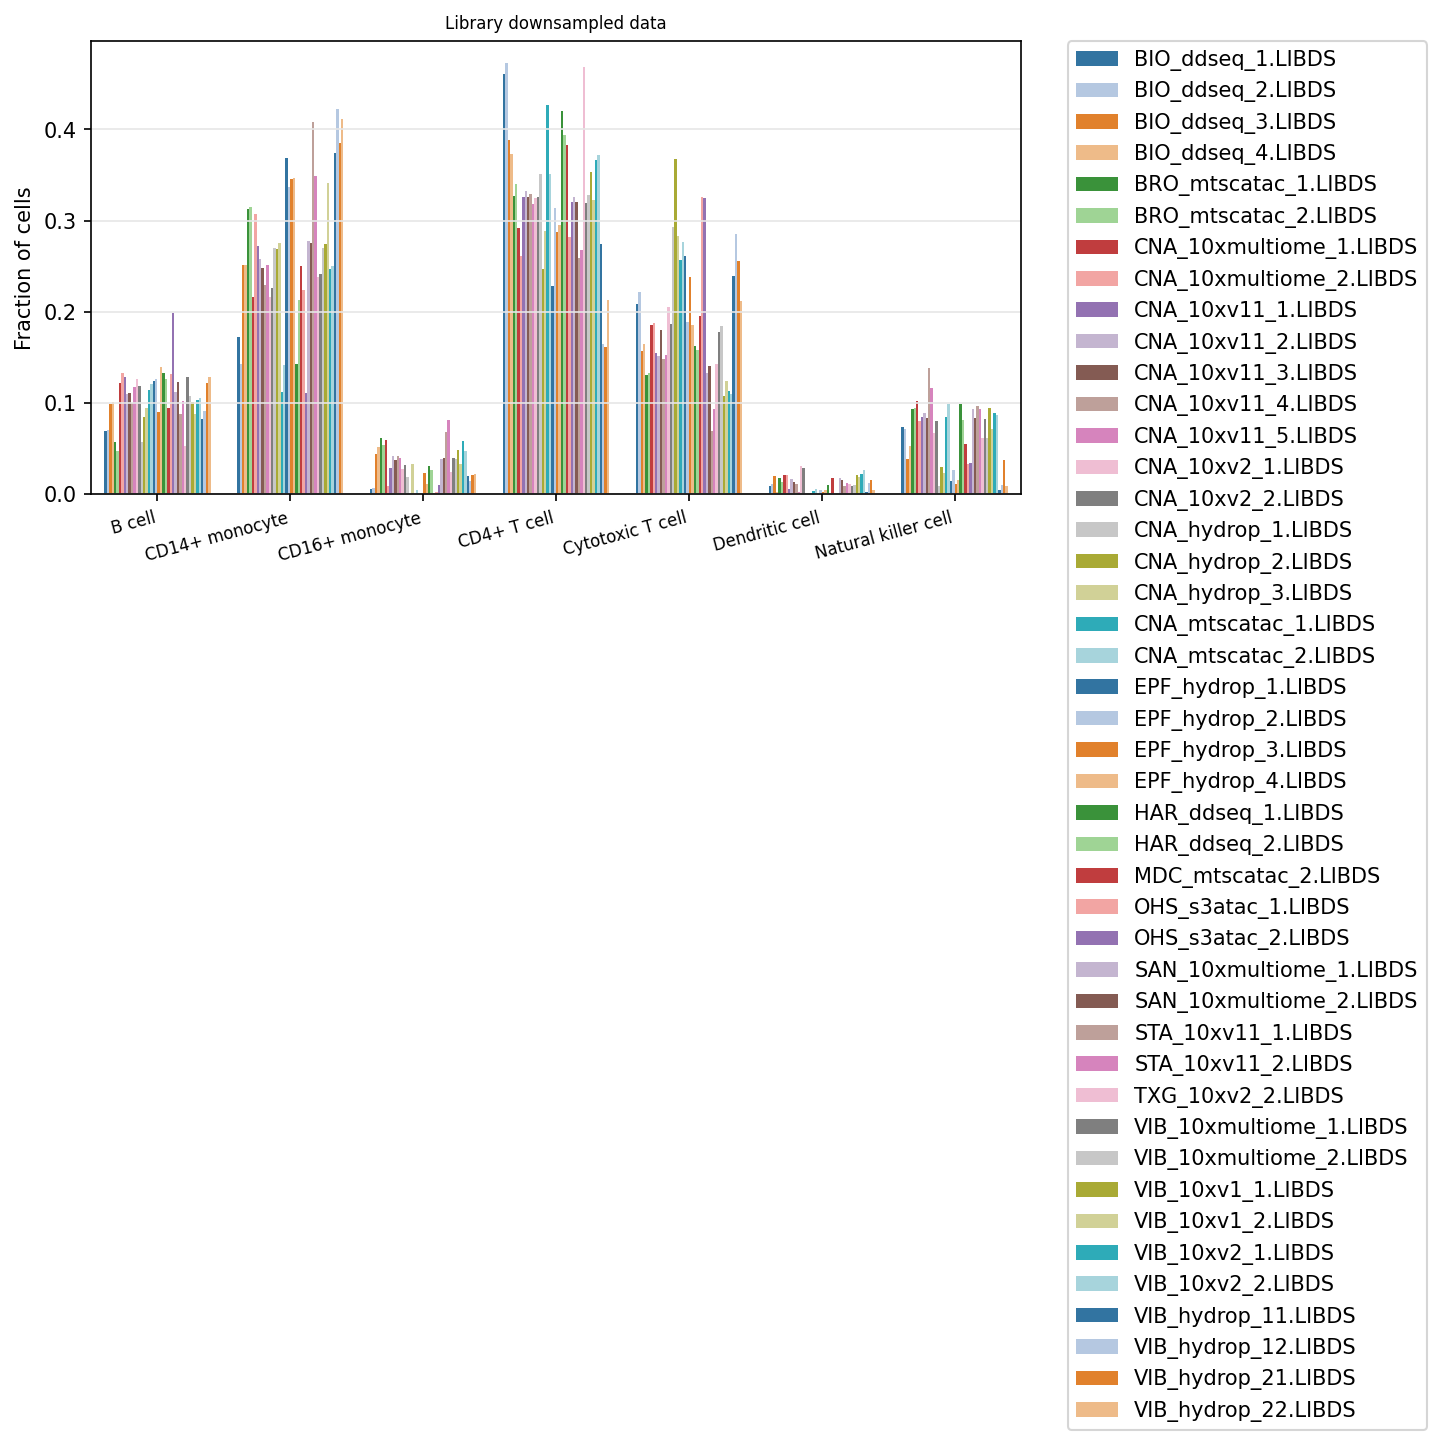

In [383]:
fig, ax = plt.subplots(1,1, figsize=(8,4), dpi=150 )
plot_cell_type_dist(tp, ax, title="Library downsampled data", order=sorted(ct_pred.keys()))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.tight_layout()
# plt.savefig(f'plts_pub/libds_cell_distribution.png', transparent=False, bbox_inches='tight')
# plt.savefig(f'plts_pub/libds_cell_distribution.svg', transparent=False, bbox_inches='tight')